In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Prep Data Files for Finetuning

In [2]:
import json
import uuid
import numpy as np
from PIL import Image
import os
import pandas as pd
import random

In [3]:
#set work path
project_path = "/content/drive/My Drive/DATASCI210/capstone_project/image_data"
os.listdir(project_path)

['recycle_data_shuffled.npz',
 'aluminum_can',
 'paper_cup',
 'data_x.npy',
 'data_y.npy',
 'others',
 'data_x_2.npy',
 'data_y_2.npy',
 'cardboard_box',
 'test_x_data.npy',
 'test_y_data.npy',
 'test_images']

aluminum_can


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
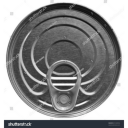

In [4]:
x_data = np.load(project_path+'/data_x.npy')
y_data = np.load(project_path+'/data_y.npy', allow_pickle=True).flatten()

#check one
print(y_data[0])
display(x_data[0])

##Generate json and train+val df

In [5]:
# target for stage 1 output

target_sen = {'aluminum_can': 'metal food can',
              'paper_cup': 'paper cup',
              'boxes':'paper box',
              'soda_can':'aluminum beverage can',
              'glass_bottle':'glass bottle',
              'plastic_bottle':'plastic bottle',
              'others': 'other items'}

In [6]:
def create_json_data(x_data, y_data, output_folder, train_num, prompt):

  id_list = []
  path_list = []
  target_sen_list = []


  for i in range(x_data.shape[0]):

    im = Image.fromarray(x_data[i])

    im_id = str(uuid.uuid4())
    im_path = os.path.join(output_folder, 'image/'+im_id + '.jpg')

    id_list.append(im_id)
    path_list.append(im_path)

    im.save(im_path)

    tar_sen = target_sen[y_data[i]]

    target_sen_list.append(tar_sen)

  json_df = pd.DataFrame({'id':id_list, 'path':path_list, 'target_sentence':target_sen_list})

  train_idxs = np.random.randint(0, len(json_df)-1, train_num)

  train_df = json_df[json_df.index.isin(train_idxs)]
  train_df = train_df.reset_index(drop=True)

  val_df = json_df[~json_df.index.isin(train_idxs)]
  val_df = val_df.reset_index(drop=True)

  # Save to file for referene
  train_df.to_csv(os.path.join(output_folder, 'train_df.csv'), index=False)
  val_df.to_csv(os.path.join(output_folder, 'val_df.csv'), index=False)

  json_data_list = []

  for idx in range(len(train_df)):

    json_data = {
        'id': train_df.iloc[idx]['id'],
        'image' : train_df.iloc[idx]['path'],
        'conversations': [
            {
                'from': 'human',
                'value': prompt
            },
            {
                'from': 'gpt',
                'value': train_df.iloc[idx]['target_sentence']
            }
        ]
    }

    json_data_list.append(json_data)

    json_output_path = os.path.join(output_folder, 'train_dataset.json')
    json_file = open(json_output_path, "w")
    json.dump(json_data_list, json_file, indent=4)
    json_file.close()


In [9]:
prompt_stage_1 = """
Classify the item in the image according to the following classes. Select only 1 class from the following list:

1. paper box
2. aluminum beverage can
3. plastic bottle
4. glass bottle
5. paper cup
6. metal food can
7. plastic bag
8. plastic cup
9. plastic jug
10. plastic takeout container
11. styrofoam cup

Output only the class name but not the class number."""

In [10]:
finetune_path = "/content/drive/My Drive/DATASCI210/capstone/"

# os.makedirs(finetune_path)
os.makedirs(finetune_path+"image")

os.listdir(finetune_path)

['image']

In [11]:
create_json_data(x_data,
                 y_data,
                 finetune_path,
                 529,
                 prompt_stage_1)

In [12]:
# os.listdir(os.path.join(finetune_path, 'json/'))
len(os.listdir(finetune_path+"image"))

529

In [ ]:
# import shutil

# src_dir = "/content/LLaVA/capstone"
# dst_dir = "/content/drive/My Drive/DATASCI210/capstone"
# shutil.copytree(src_dir, dst_dir)

# os.listdir(dst_dir)

['train_df.csv', 'train_dataset.json', 'val_df.csv', 'image']

#Set up

In [2]:
import os

# Clone the LLaVA repository
!git clone https://github.com/haotian-liu/LLaVA.git
os.chdir("LLaVA")
os.getcwd()

Cloning into 'LLaVA'...
remote: Enumerating objects: 2297, done.
remote: Total 2297 (delta 0), reused 0 (delta 0), pack-reused 2297 (from 1)
Receiving objects: 100% (2297/2297), 13.71 MiB | 13.97 MiB/s, done.
Resolving deltas: 100% (1404/1404), done.


'/content/LLaVA'

In [3]:
!pip install --upgrade pip  # enable PEP 660 support
!pip install -e .

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 62.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Obtaining file:///content/LLaVA
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 111.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
#colab requires restarting runtime, run below if so to change directory back to LLaVA

import os
os.chdir("LLaVA")
os.getcwd()

'/content/LLaVA'

#Fine-tuning

In [2]:
!pip install -e ".[train]"
!pip install flash-attn --no-build-isolation

Obtaining file:///content/LLaVA
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Building editable for llava (pyproject.toml) ... done
  Created wheel for llava: filename=llava-1.2.2.post1-0.editable-py3-none-any.whl size=17850 sha256=dae90be81c2fff8ff847a65b6c2ed719ca2b00d85e06b1d31ab25fef246b5244
  Stored in directory: /tmp/pip-ephem-wheel-cache-_huhyi15/wheels/04/eb/cc/8992f8302dd174d3e63566efe82795f070b535b03506b75ffb
  Created wheel for deepspeed: filename=deepspeed-0.12.6-py3-none-any.whl size=1306719 sha256=bf97403e3342c6f90904920c02ecb306e04e20c77c4eee2bfd09d86852abbaa0
  Stored in directory: /root/.cache/pip/wheels/a3/dc/a2/f585faaed4dec84108916dcc8e8a7c129a216df8202ca32984
Successfully built llava de

In [3]:
!git pull
!pip install -e .

# if encounter import errors during upgrade, run below, otherwise can skip
# !pip install flash-attn --no-build-isolation --no-cache-dir

Already up to date.
Obtaining file:///content/LLaVA
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for llava (pyproject.toml) ... done
  Created wheel for llava: filename=llava-1.2.2.post1-0.editable-py3-none-any.whl size=17850 sha256=cf5b17eb7cb4edbba92286c08e76d1ded9f73da1f72961e06427cb28837fc880
  Stored in directory: /tmp/pip-ephem-wheel-cache-wm9vf_my/wheels/04/eb/cc/8992f8302dd174d3e63566efe82795f070b535b03506b75ffb
Successfully built llava
  Attempting uninstall: llava
    Found existing installation: llava 1.2.2.post1
    Uninstalling llava-1.2.2.post1:
      Successfully uninstalled llava-1.2.2.post1


In [4]:
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path

model_path = "liuhaotian/llava-v1.5-7b"

tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=model_path,
    model_base=None,
    model_name=get_model_name_from_path(model_path),
    offload_folder="/content/llava_model"
)

[2024-12-08 13:31:30,472] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin.index.json:   0%|          | 0.00/27.1k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.54G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.76k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

In [5]:
import shutil

src_dir = "/content/drive/My Drive/DATASCI210/capstone"
dst_dir = "/content/LLaVA/capstone"
shutil.copytree(src_dir, dst_dir)

if os.path.exists("/content/LLaVA/capstone/llava-v1.5-13b-task-lora"):
  shutil.rmtree("/content/LLaVA/capstone/llava-v1.5-13b-task-lora")

os.listdir(dst_dir)

['train_df.csv', 'train_dataset.json', 'image']

In [6]:
os.mkdir('/content/LLaVA/capstone/llava-v1.5-13b-task-lora')
os.mkdir('/content/LLaVA/capstone/finetuned_llava')

os.listdir('/content/LLaVA/capstone')

['train_df.csv',
 'finetuned_llava',
 'llava-v1.5-13b-task-lora',
 'train_dataset.json',
 'image']

In [ ]:
## To-do manually:
#  update stage3_max_live_parameters and stage3_max_reuse_distance in ./scripts/zero3.json from default 1e9 to 5e8

In [7]:
DATA_PATH = "./capstone/train_dataset.json"
IMAGE_FOLDER = "./capstone/image"
OUTPUT_DIR = "./capstone/llava-v1.5-13b-task-lora"

In [8]:
# Command to run the script
finetune_script = f'''
deepspeed llava/train/train_mem.py \
    --lora_enable True --lora_r 128 --lora_alpha 256 --mm_projector_lr 2e-5 \
    --deepspeed ./scripts/zero3_offload.json \
    --model_name_or_path liuhaotian/llava-v1.5-13b \
    --version v1 \
    --data_path {DATA_PATH} \
    --image_folder {IMAGE_FOLDER} \
    --vision_tower openai/clip-vit-large-patch14-336 \
    --mm_projector_type mlp2x_gelu \
    --mm_vision_select_layer -2 \
    --mm_use_im_start_end False \
    --mm_use_im_patch_token False \
    --image_aspect_ratio pad \
    --group_by_modality_length True \
    --bf16 True \
    --output_dir {OUTPUT_DIR} \
    --num_train_epochs 1 \
    --per_device_train_batch_size 8 \
    --per_device_eval_batch_size 4 \
    --gradient_accumulation_steps 16 \
    --evaluation_strategy "no" \
    --save_strategy "steps" \
    --save_steps 50000 \
    --save_total_limit 1 \
    --learning_rate 2e-4 \
    --weight_decay 0. \
    --warmup_ratio 0.03 \
    --lr_scheduler_type "cosine" \
    --logging_steps 1 \
    --tf32 True \
    --model_max_length 2048 \
    --gradient_checkpointing True \
    --dataloader_num_workers 4 \
    --lazy_preprocess True \
    --report_to wandb
'''

In [ ]:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

In [9]:
# Execute the fine-tuning script
!{finetune_script}

[2024-12-08 13:33:49,738] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)
2024-12-08 13:33:52.488595: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-08 13:33:52.509599: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-08 13:33:52.515901: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 13:33:53.763911: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[2024-12-08 13:33:54,831] [WARNING] [runner.py:202:fetch_hostfile] Unable to find hostfile, will proceed with training wi

In [10]:
os.listdir("./capstone/llava-v1.5-13b-task-lora")

['adapter_config.json',
 'README.md',
 'adapter_model.safetensors',
 'config.json',
 'non_lora_trainables.bin',
 'trainer_state.json']

In [11]:
!python /content/LLaVA/scripts/merge_lora_weights.py --model-path /content/LLaVA/capstone/llava-v1.5-13b-task-lora --model-base liuhaotian/llava-v1.5-13b --save-model-path /content/LLaVA/capstone/finetuned_llava

[2024-12-08 13:48:16,113] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)
2024-12-08 13:48:17.840366: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-08 13:48:17.862280: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-08 13:48:17.868858: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 13:48:19.228186: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is depreca

In [12]:
os.listdir("./capstone/finetuned_llava")

['model-00006-of-00006.safetensors',
 'model.safetensors.index.json',
 'model-00004-of-00006.safetensors',
 'model-00001-of-00006.safetensors',
 'generation_config.json',
 'special_tokens_map.json',
 'config.json',
 'model-00002-of-00006.safetensors',
 'model-00005-of-00006.safetensors',
 'tokenizer.model',
 'tokenizer_config.json',
 'model-00003-of-00006.safetensors']

In [13]:
# import shutil, os

src_dir = "/content/LLaVA/capstone/llava-v1.5-13b-task-lora"
dst_dir = "/content/drive/My Drive/DATASCI210/capstone/llava-v1.5-13b-task-lora"

if os.path.exists(dst_dir):
  shutil.rmtree(dst_dir)

shutil.copytree(src_dir, dst_dir)

os.listdir(dst_dir)

['adapter_config.json',
 'README.md',
 'adapter_model.safetensors',
 'config.json',
 'non_lora_trainables.bin',
 'trainer_state.json']

In [14]:
# import shutil, os

src_dir = "/content/LLaVA/capstone/finetuned_llava"
dst_dir = "/content/drive/My Drive/DATASCI210/capstone_project/finetuned_llava"

if os.path.exists(dst_dir):
  shutil.rmtree(dst_dir)

shutil.copytree(src_dir, dst_dir)

os.listdir(dst_dir)

['model-00006-of-00006.safetensors',
 'model.safetensors.index.json',
 'model-00004-of-00006.safetensors',
 'model-00001-of-00006.safetensors',
 'generation_config.json',
 'special_tokens_map.json',
 'config.json',
 'model-00002-of-00006.safetensors',
 'model-00005-of-00006.safetensors',
 'tokenizer.model',
 'tokenizer_config.json',
 'model-00003-of-00006.safetensors']

#Evaluation

In [2]:
import torch
from PIL import Image
from tqdm import tqdm #progress bar

from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import tokenizer_image_token, process_images, get_model_name_from_path

import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [3]:
def llava_infer(question, numpy_image, num_token, tokenizer, model, image_processor):

  disable_torch_init()

  qs = DEFAULT_IMAGE_TOKEN + '\n' + question
  conv = conv_templates["default"].copy()
  conv.append_message(conv.roles[0], qs)
  conv.append_message(conv.roles[1], None)
  prompt = conv.get_prompt()
  input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()

  image = Image.fromarray(np.uint8(numpy_image)).convert('RGB')
  image_tensor = process_images([image], image_processor, model.config)[0]

  with torch.inference_mode():
      output_ids = model.generate(
          input_ids,
          images=image_tensor.unsqueeze(0).half().cuda(),
          image_sizes=[image.size],
          do_sample=False,
          temperature=0,
          top_p=None,
          num_beams=1,
          max_new_tokens=num_token,
          use_cache=True)

  output = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip()

  return output

In [4]:
#prompt set up
question = """
Classify the item in the image according to the following classes. Select only 1 class from the following list:

1. paper box
2. aluminum beverage can
3. plastic bottle
4. glass bottle
5. paper cup
6. metal food can
7. plastic bag
8. plastic cup
9. plastic jug
10. plastic takeout container
11. styrofoam cup

Output only the class name but not the class number."""

cardboard_box


array([[[ 26,  33,  33],
        [ 37,  41,  39],
        [ 37,  38,  37],
        ...,
        [ 48,  44,  41],
        [ 56,  51,  48],
        [ 65,  57,  55]],

       [[ 13,  32,  50],
        [ 10,  29,  41],
        [  9,  28,  34],
        ...,
        [ 55,  51,  48],
        [ 57,  52,  49],
        [ 60,  52,  50]],

       [[ 11,  39,  71],
        [ 11,  37,  65],
        [ 10,  35,  58],
        ...,
        [ 56,  51,  48],
        [ 60,  55,  52],
        [ 59,  52,  50]],

       ...,

       [[160, 143, 128],
        [161, 145, 130],
        [124, 107,  95],
        ...,
        [141, 117,  83],
        [138, 114,  80],
        [135, 111,  77]],

       [[125, 111,  96],
        [148, 132, 118],
        [157, 140, 125],
        ...,
        [144, 120,  86],
        [138, 114,  80],
        [134, 110,  76]],

       [[116, 103,  87],
        [155, 139, 124],
        [149, 135, 119],
        ...,
        [141, 117,  83],
        [135, 111,  77],
        [138, 114,  80]]], dtype=uint8)
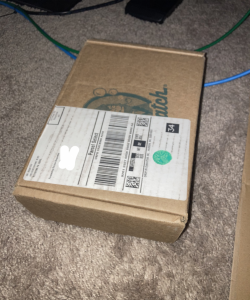

In [5]:
x_data = np.load("/content/drive/My Drive/DATASCI210/capstone_project/image_data/test_x_data.npy")
y_data = np.load("/content/drive/My Drive/DATASCI210/capstone_project/image_data/test_y_data.npy", allow_pickle=True).flatten()

#check one
print(y_data[0])
display(x_data[0])

In [6]:
np.unique(y_data)

array(['cardboard_box', 'glass_bottle', 'metal_beverage_can',
       'metal_food_can', 'paper_cup', 'plastic_bag', 'plastic_bottle',
       'plastic_cup', 'plastic_jug', 'plastic_takeout_container',
       'styrofoam_cup'], dtype='<U25')

In [7]:
reps = {'cardboard_box': 'paper box',
        'glass_bottle': 'glass bottle',
        'metal_beverage_can': 'aluminum beverage can',
        'metal_food_can': 'metal food can',
        'paper_cup': 'paper cup',
        'plastic_bag': 'plastic bag',
        'plastic_bottle':'plastic bottle',
        'plastic_cup':'plastic cup',
        'plastic_jug':'plastic jug',
        'plastic_takeout_container':'plastic takeout container',
        'styrofoam_cup': 'styrofoam cup'}

y_data=[reps.get(x,x) for x in y_data]

np.unique(y_data)

array(['aluminum beverage can', 'glass bottle', 'metal food can',
       'paper box', 'paper cup', 'plastic bag', 'plastic bottle',
       'plastic cup', 'plastic jug', 'plastic takeout container',
       'styrofoam cup'], dtype='<U25')

##LLaVA 1.5

In [8]:
model_path = "liuhaotian/llava-v1.5-7b"

tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=model_path,
    model_base=None,  # Adjust if necessary based on your training configuration
    model_name=get_model_name_from_path(model_path)
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin.index.json:   0%|          | 0.00/27.1k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.54G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.76k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

In [9]:
labels=[]
pred_labels=[]

for i in tqdm(range(x_data.shape[0])):
  if y_data[i]!='other items':
    labels.append(y_data[i])
    pred = llava_infer(question, x_data[i], 20, tokenizer, model, image_processor)
    pred_labels.append(pred.lower())

  0%|          | 0/84 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `None` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
100%|██████████| 84/84 [00:20<00:00,  4.20it/s]


In [10]:
np.unique(labels)

array(['aluminum beverage can', 'glass bottle', 'metal food can',
       'paper box', 'paper cup', 'plastic bag', 'plastic bottle',
       'plastic cup', 'plastic jug', 'plastic takeout container',
       'styrofoam cup'], dtype='<U25')

In [11]:
np.unique(pred_labels)

array(['1', '10', '11', '2', '3', '4', '6', '7', 'aluminum beverage can',
       'glass bottle', 'paper box', 'paper cup', 'plastic bottle'],
      dtype='<U21')

In [12]:
# 1. paper box
# 2. aluminum beverage can
# 3. plastic bottle
# 4. glass bottle
# 5. paper cup
# 6. metal food can
# 7. plastic bag
# 8. plastic cup
# 9. plastic jug
# 10. plastic takeout container
# 11. styrofoam cup

reps = {'1': 'paper box',
        '10': 'plastic takeout container',
        '11': 'styrofoam cup',
        '2': 'aluminum beverage can',
        '3': 'plastic bottle',
        '4': 'glass bottle',
        '6': 'metal food can',
        '7': 'plastic bag'}

pred_labels=[reps.get(x,x) for x in pred_labels]

np.unique(pred_labels)

array(['aluminum beverage can', 'glass bottle', 'metal food can',
       'paper box', 'paper cup', 'plastic bag', 'plastic bottle',
       'plastic takeout container', 'styrofoam cup'], dtype='<U25')

Text(50.7222222222222, 0.5, 'True')

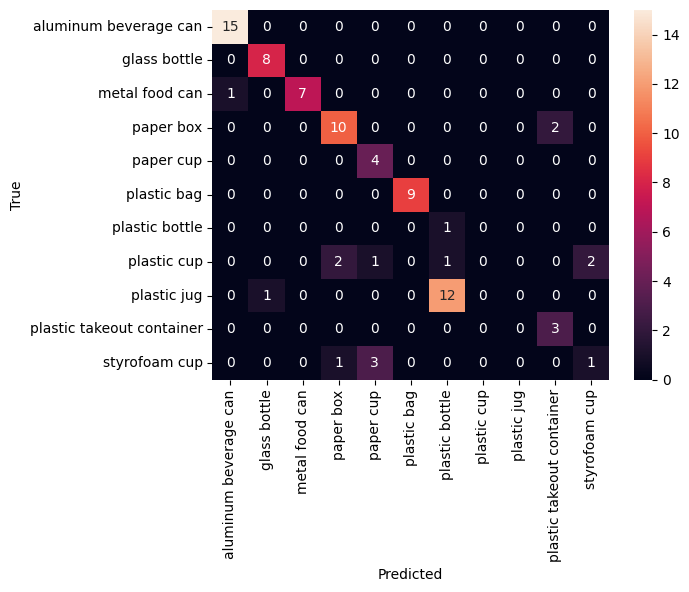

In [13]:
names=np.unique(labels)
cm = confusion_matrix(labels, pred_labels, labels=names)
sns.heatmap(
    cm,
    annot=True,
    fmt='g',
    xticklabels=names,
    yticklabels=names)
plt.xlabel("Predicted")
plt.ylabel("True")

In [14]:
print(classification_report(labels, pred_labels, target_names=names, digits=4))

                           precision    recall  f1-score   support

    aluminum beverage can     0.9375    1.0000    0.9677        15
             glass bottle     0.8889    1.0000    0.9412         8
           metal food can     1.0000    0.8750    0.9333         8
                paper box     0.7692    0.8333    0.8000        12
                paper cup     0.5000    1.0000    0.6667         4
              plastic bag     1.0000    1.0000    1.0000         9
           plastic bottle     0.0714    1.0000    0.1333         1
              plastic cup     0.0000    0.0000    0.0000         6
              plastic jug     0.0000    0.0000    0.0000        13
plastic takeout container     0.6000    1.0000    0.7500         3
            styrofoam cup     0.3333    0.2000    0.2500         5

                 accuracy                         0.6905        84
                macro avg     0.5546    0.7189    0.5857        84
             weighted avg     0.6303    0.6905    0.6478    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##LLaVA 1.5 (LoRA Finetuned)

In [15]:
# from llava.model.builder import load_pretrained_model
# from llava.mm_utils import get_model_name_from_path

model_path = "/content/drive/My Drive/DATASCI210/capstone_project/finetuned_llava"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=model_path,
    model_base=None,  # Adjust if necessary based on your training configuration
    model_name=get_model_name_from_path(model_path),
    device=device
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Some weights of the model checkpoint at /content/drive/My Drive/DATASCI210/capstone_project/finetuned_llava were not used when initializing LlavaLlamaForCausalLM: ['model.vision_tower.vision_tower.vision_model.embeddings.class_embedding', 'model.vision_tower.vision_tower.vision_model.embeddings.patch_embedding.weight', 'model.vision_tower.vision_tower.vision_model.embeddings.position_embedding.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm1.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm1.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm2.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm2.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.mlp.fc1.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.mlp.fc1.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.mlp.fc2.bias', 'model.vision_tower.vision

In [16]:
labels=[]
pred_labels=[]

for i in tqdm(range(x_data.shape[0])):
  if y_data[i]!='other items':
    labels.append(y_data[i])
    pred = llava_infer(question, x_data[i], 20, tokenizer, model, image_processor)
    pred_labels.append(pred.lower())

  0%|          | 0/84 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `None` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
100%|██████████| 84/84 [00:47<00:00,  1.76it/s]


In [17]:
np.unique(labels)

array(['aluminum beverage can', 'glass bottle', 'metal food can',
       'paper box', 'paper cup', 'plastic bag', 'plastic bottle',
       'plastic cup', 'plastic jug', 'plastic takeout container',
       'styrofoam cup'], dtype='<U25')

In [18]:
np.unique(pred_labels)

array(['aluminum beverage can', 'glass bottle', 'paper box', 'paper cup',
       'plastic bottle'], dtype='<U21')

In [ ]:
# 1. paper box
# 2. aluminum beverage can
# 3. plastic bottle
# 4. glass bottle
# 5. paper cup
# 6. metal food can
# 7. plastic bag
# 8. plastic cup
# 9. plastic jug
# 10. plastic takeout container
# 11. styrofoam cup

reps = {'plastic cup': 'other items'}

pred_labels=[reps.get(x,x) for x in pred_labels]

np.unique(pred_labels)

array(['aluminum beverage can', 'glass bottle', 'metal food can',
       'other items', 'paper box', 'paper cup', 'plastic bottle'],
      dtype='<U21')

Text(50.7222222222222, 0.5, 'True')

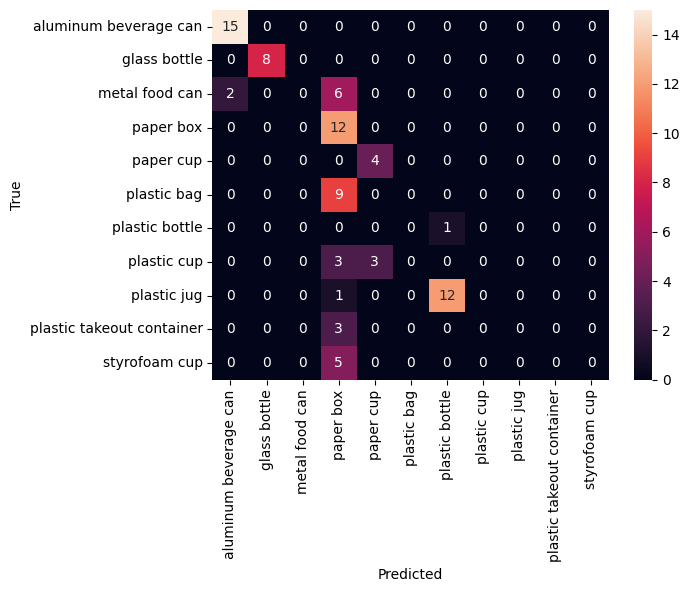

In [19]:
names=np.unique(labels)
cm = confusion_matrix(labels, pred_labels, labels=names)
sns.heatmap(
    cm,
    annot=True,
    fmt='g',
    xticklabels=names,
    yticklabels=names)
plt.xlabel("Predicted")
plt.ylabel("True")

In [20]:
print(classification_report(labels, pred_labels, target_names=names, digits=4))

                           precision    recall  f1-score   support

    aluminum beverage can     0.8824    1.0000    0.9375        15
             glass bottle     1.0000    1.0000    1.0000         8
           metal food can     0.0000    0.0000    0.0000         8
                paper box     0.3077    1.0000    0.4706        12
                paper cup     0.5714    1.0000    0.7273         4
              plastic bag     0.0000    0.0000    0.0000         9
           plastic bottle     0.0769    1.0000    0.1429         1
              plastic cup     0.0000    0.0000    0.0000         6
              plastic jug     0.0000    0.0000    0.0000        13
plastic takeout container     0.0000    0.0000    0.0000         3
            styrofoam cup     0.0000    0.0000    0.0000         5

                 accuracy                         0.4762        84
                macro avg     0.2580    0.4545    0.2980        84
             weighted avg     0.3249    0.4762    0.3662    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
